# Load up our libraries

In [2]:
# all purpose
import datetime, re
from math import radians, cos, sin, asin, sqrt

# for talking to SQL databases
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# json and XML parsing
import json
from pprint import pprint
from urllib2 import urlopen
from pyquery import PyQuery as pq


# all purpose data analysis and plotting
#from scipy import stats
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#%matplotlib inline
#import seaborn as sns

import pickle

Define this function for computing distances in meters from (lat,lon) coordinates

In [3]:
# We will need this function to compute the distance between two (lat,lon) points, in meters
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    meters = 6367 * c * 1000
    return meters

## Load data from SQL database (necessary only to load Muni routes and estlabish connection to database)

We need to connect to the PostgresSQL database that I am reading the NextBus Muni data into, which is called 'sf_muni_arrivals' in our case.

**This cell must be run.**

In [4]:
# Change depending on whether I am running on AWS or local
# dbname = 'sf_muni_arrivals'
# username = 'dstone'
# table = 'nextbus_write_2016_01_15'
dbname = 'sf_muni_arrivals_aws'
username = 'ec2-user'
table = 'nextbus_realtime_with_predictions'

# Open up an engine, that we will use to create the database if it doesn't exist
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

if not database_exists(engine.url):
    create_database(engine.url)
    
# If I want to filter the data first:
# connect:
db_con = None
db_con = psycopg2.connect(database = dbname, user = username)

These commands load the entire database into a pandas dataframe. I only used this to grab the list of Muni routes. It is not necessary below.

In [5]:
# the table name is 'nextbus':
# only run this code if the list_of_muni_routes needs to be reestablished
# sql_query = """
# SELECT * FROM {table};
# """.format(table=table)
# nbdata = pd.read_sql_query(sql_query,db_con)

In [6]:
# routeslist = pd.unique(nbdata['route'].ravel())
# list_of_muni_routes = pd.DataFrame(data=routeslist, index = range(len(routeslist)), columns=['route'])

# # Clean up a bit
# list_of_muni_routes = list_of_muni_routes[(list_of_muni_routes.route.isnull() == False) & (list_of_muni_routes.route != 'Inspectors') & (list_of_muni_routes.route != 'Training')]
# list_of_muni_routes = list_of_muni_routes[list_of_muni_routes.route != '']
# np.save('list_of_muni_routes',np.asarray(list_of_muni_routes).ravel())
list_of_muni_routes = np.load('list_of_muni_routes.npy')

## Defining a classifier with differences of prediction times compared to scheduled frequency

We read in some data. The goal here is to MAKE A PARAMETER abs(pred1-pred2)/freq, THEN PRODUCED A 'BUNCHED' column that is a smearing over 5-7 entries (NOTE WE MUST ORDER BY TIME). First we must figure out how to look up the frequency in the frequency tables

This loads the frequency tables for computing the bunching (for each route)

In [17]:
freq_dict = {}
for route in list_of_muni_routes:
    my_key = 'route_'+str(route)
    if my_key not in freq_dict:
        freq_dict[my_key] = 0

# load frequency tables
for route in list_of_muni_routes:
    freqvar = 'route_'+str(route)
    with open('route_frequencies/route_'+str(route)+'_frequencies.pkl','rb') as input:
        freq_dict[freqvar] = pickle.load(input)
        freq_dict[freqvar].index = freq_dict[freqvar]['time']

This will find the frequency for a given route at a given time. We will use this to run over all rows in our database

In [46]:
def find_freq(pair_route, pair_time):
    tmp_key = 'route_'+str(pair_route)
    # Must turn year into 1970, gah
    # Find the first time in the time interval (pair_time, pair_time + 2 hours)
    # (expect minimum frequency of 2 hour on Muni buses)
    t0 = '1970-01-01 '+str(pair_time.hour)+':'+str(pair_time.minute)+':00'
    t1 = '1970-01-01 '+str(pair_time.hour+2)+':'+str(pair_time.minute)+':00'
    return freq_dict[tmp_key].loc[t0:t1]['freq'][0]

In [31]:
t0 = df30.loc[0]['time']
#freq_dict['route_30'].loc[str(t0):str(t0+pd.Timedelta(minutes=30))]

print t0

2016-01-27 13:11:55


In [43]:
t0s='1970-01-01 '+str(t0.hour)+':'+str(t0.minute)+':00'

In [45]:
print str(t0.hour)

print str(t0.hour + 1)

13
14


In [47]:
df_route_dict = {}
for route in list_of_muni_routes:
    my_key = 'route_'+str(route)
    if my_key not in df_route_dict:
        df_route_dict[my_key] = 0
        

In [10]:
for route in list_of_muni_routes[:3]:
    tmp_key = 'route_'+str(route)
    sql_query = '''SELECT * FROM {table} WHERE route_x = \'{route}\' LIMIT 1000;'''.format(table=table,route=route)
    #sql_query = '''SELECT * FROM {table};'''.format(table=table)
    df_route_dict[tmp_key] = pd.read_sql_query(sql_query, db_con)
    # useless column
    df_route_dict[tmp_key].drop('index', inplace=True, axis=1)
    # Must subtract 8 hours from row['time'], since that is actually UTC time
    df_route_dict[tmp_key]['freq'] = df_route_dict[tmp_key].apply(lambda row: find_freq(row['route_x'],row['time']- pd.Timedelta(hours=8)), axis=1)
    df_route_dict[tmp_key]['normed_pred_diff'] = df_route_dict[tmp_key].apply(lambda row: float(abs((float(row['pred_x'])-float(row['pred_y']))/float(row['freq']))), axis=1)
    print 'route '+str(route)+' done!'

TypeError: ("cannot do slice indexing on <class 'pandas.core.index.Int64Index'> with these indexers [2016-01-27 00:35:38] of <type 'str'>", u'occurred at index 0')

In [48]:
sql_query = '''SELECT * FROM {table} WHERE route_x = \'{route}\' LIMIT 1000;'''.format(table=table,route='30')
#sql_query = '''SELECT * FROM {table};'''.format(table=table)
df30 = pd.read_sql_query(sql_query, db_con)
# useless column
df30.drop('index', inplace=True, axis=1)

In [49]:
df30.head(10)

,lat_x,lon_x,pred_x,route_x,speed_x,time,lat_y,lon_y,pred_y,speed_y,dist
0,37.80133,-122.43250,29,30,37,2016-01-27 13:11:55,37.79957,-122.43599,40,25,401.761913
1,37.80218,-122.42588,27,30,33,2016-01-27 13:13:36,37.80030,-122.44052,38,33,1630.725417
2,37.80030,-122.44052,5,30,33,2016-01-27 13:13:36,37.79134,-122.44357,8,29,632.588945
3,37.80531,-122.42418,25,30,20,2016-01-27 13:15:16,37.80062,-122.44470,36,9,2297.355977
4,37.80062,-122.44470,3,30,9,2016-01-27 13:15:16,37.79224,-122.43633,7,3,1055.770445
5,37.80558,-122.42159,23,30,29,2016-01-27 13:16:14,37.79999,-122.44268,33,9,2367.188237
6,37.80591,-122.41909,22,30,27,2016-01-27 13:17:53,37.80079,-122.43652,30,9,1960.792594
7,37.80079,-122.43652,30,30,9,2016-01-27 13:17:53,37.79487,-122.43677,40,16,353.946517
8,37.80396,-122.41547,20,30,42,2016-01-27 13:19:25,37.80154,-122.43066,29,33,1694.136988
9,37.80154,-122.43066,29,30,33,2016-01-27 13:19:25,37.79787,-122.43569,39,18,600.230129


In [50]:
find_freq(30,df30.loc[0]['time'])

826.0

In [52]:
freq_dict['route_30'][freq_dict['route_30']['freq'] > 100]

,time,freq
time,,
1969-12-31 23:59:59,1969-12-31 23:59:59,896
1970-01-01 09:13:00,1970-01-01 09:13:00,553
1969-12-31 23:59:59,1969-12-31 23:59:59,886
1970-01-01 09:25:00,1970-01-01 09:25:00,565
1969-12-31 23:59:59,1969-12-31 23:59:59,874
1970-01-01 10:13:00,1970-01-01 10:13:00,613
1969-12-31 23:59:59,1969-12-31 23:59:59,826
1970-01-01 10:37:00,1970-01-01 10:37:00,637
1969-12-31 23:59:59,1969-12-31 23:59:59,802


Next: run over **all** routes, just pull indiscriminantly from database, compute freqs, then do tasks below

Add the column that decides whether or not bunching occurs

In [58]:
def pass_threshold(percentile):
    if percentile >= 0.8:
        return 1
    else:
        return 0

bunched_scores=map(pass_threshold,np.convolve(df_all['dist_percentile'],[1,1,1,1,1,1,1])/7)
# Take off first (7-1)/2 = 3 and last 3
bunched_scores=bunched_scores[3:]
bunched_scores=bunched_scores[:-3]

df_all['bunched'] = bunched_scores

In [59]:
df_all['bunched'].value_counts()

0    205635
1     37835
Name: bunched, dtype: int64

In [407]:
cor_mat = df_all.corr()

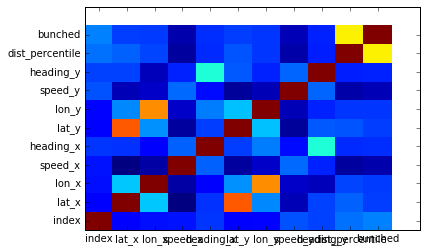

In [408]:
plt.pcolor(cor_mat)
plt.yticks(np.arange(0.5, len(cor_mat.index), 1), cor_mat.index)
plt.xticks(np.arange(0.5, len(cor_mat.columns), 1), cor_mat.columns)
plt.show()


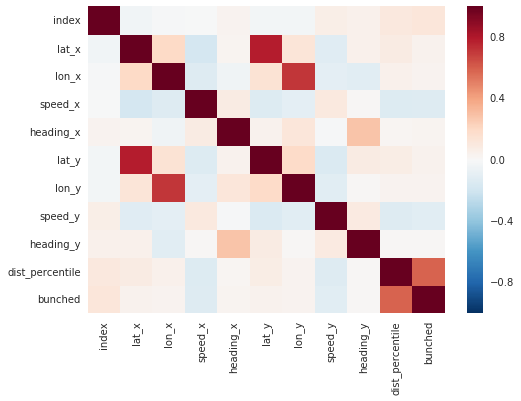

In [410]:
sns.heatmap(cor_mat)

Write to the SQL database

In [ ]:
df_all.to_sql('vehicle_pairs_2016_01_15', engine, if_exists='replace')

## Perform random forest fit

In [60]:
from sklearn.ensemble import RandomForestClassifier
# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = 250)

Separate the data into training and testing

In [177]:
# Reserve 0.4 of data for testing
test_data = df_all.sample(frac=0.4, replace=False)
# 0.6 for training
train_data = df_all.loc[df_for_fit.index.isin(test.index)]

For the y training data, we just take the 'bunched' column and flatten it
For the x training data, we use dmatrices, as usual.

Note we use the mysterious patsy 'formula' to select the features we want to fit against.

In [196]:
formula_tmp = 'bunched ~ C(route_x) + time.dt.hour + time.dt.minute + lat_x + lon_x + speed_x + lat_y + lon_y + speed_y + dist_percentile'

ytmp, xtmp = patsy.dmatrices(formula_tmp, data=train_data[0:1], return_type='dataframe')

In [197]:
xtmp.head()

,Intercept,time.dt.hour,time.dt.minute,lat_x,lon_x,speed_x,lat_y,lon_y,speed_y,dist_percentile
0,1,0,10,37.79203,-122.48172,0,37.71993,-122.47606,4.72222,0.125471


In [62]:
import patsy
from sklearn import cross_validation, metrics, linear_model, svm

**Taking out categorical variable for now on route_x-- but this should definitely be included once I learn to include this with individual points**

(One trick when computing probs on individual points would be to add dummy rows that iterate over all routes, so all categories are there, then only take the prediction on the first row)

In [322]:
#formula = 'bunched ~ time.dt.hour + time.dt.minute + lat_x + lon_x + speed_x + C(route_x) + lat_y + lon_y + speed_y + dist_percentile'
formula = 'bunched ~ time.dt.hour + time.dt.minute + lat_x + lon_x + speed_x  + lat_y + lon_y + speed_y + dist_percentile'


# do with the training data
ytrain, xtrain = patsy.dmatrices(formula, data=train_data, return_type='dataframe')
ytrain = np.asarray(ytrain).ravel()

# same with the test data
ytest, xtest = patsy.dmatrices(formula, data=test_data, return_type='dataframe')
ytest = np.asarray(ytest).ravel()

In [323]:
# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(xtrain,ytrain)

# Take the same decision trees and run it on the test data
#output = forest.predict(test_data)

Let's look at the accuracy and compute the ROC

In [324]:
# cv = 'cross-validations' = 'no. of k-foldings to do' in the language I used above
scores_train = cross_validation.cross_val_score(forest, xtrain, ytrain, cv=4)
print scores_train
# With 68% CLs on the accuracy
print 'Average accuracy on cross-validated training set: %0.3f ± %0.3f' % (scores_train.mean(),scores_train.std())

[ 0.94130935  0.93867828  0.93071015  0.92931077]
Average accuracy on cross-validated training set: 0.935 ± 0.005


Now measure accuracy on the test set:

In [325]:
predictions_cv = cross_validation.cross_val_predict(forest, xtest, ytest, cv=4)
predictions = forest.predict_proba(xtest) 

In [326]:
score_test = metrics.accuracy_score(ytest, predictions_cv)
print 'Accuracy on test data: %0.3f' % score_test

Accuracy on test data: 0.947


And finally a pretty ROC:

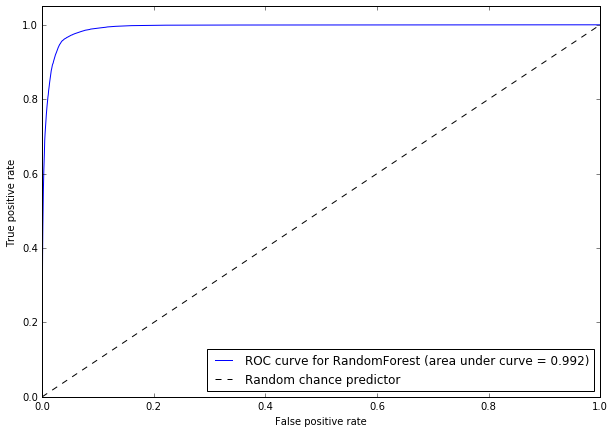

In [327]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(ytest, predictions[:,1])
roc_auc_rf = metrics.auc(fpr_rf,tpr_rf)
f, a = plt.subplots()
f.set_size_inches(10,7)

a.plot(fpr_rf, tpr_rf, label='ROC curve for RandomForest (area under curve = %0.3f)' % roc_auc_rf)
# The 50/50 fpr/tpr line
a.plot([0,1],[0,1],'k--', label='Random chance predictor')
a.set_xlim(0.0,1.0)
a.set_ylim(0.0,1.05)
a.set_xlabel('False positive rate')
a.set_ylabel('True positive rate')
a.legend(loc='lower right')

In [328]:
f.savefig('roc_rf_2016_01_21.png')

We can check to see which feature was most important

In [329]:
xtrain.iloc[1]

Intercept            1.000000
time.dt.hour         0.000000
time.dt.minute      12.000000
lat_x               37.787700
lon_x             -122.484060
speed_x             14.722200
lat_y               37.721580
lon_y             -122.472390
speed_y              6.388890
dist_percentile      0.144539
Name: 1, dtype: float64

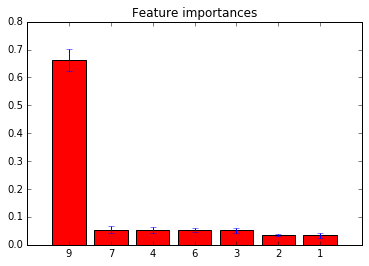

In [330]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
#print indices

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
yerr=std[indices][:7]
heights= importances[indices][:7]
indices = indices[:7]
plt.figure()
plt.title("Feature importances")
plt.bar(range(7), heights ,
       color="r", yerr=yerr, align="center")
#plt.xticks(range(xtrain.shape[1]), indices)
plt.xticks(range(len(indices)), indices)
#plt.xlim([-1, xtrain.shape[1]])
#plt.xlim([-1, 8])
plt.show()

In [331]:
plt.savefig('feature_importance_rf_2016_01_21.png')

Saving the RF fit to disk, use pickle:

with open('name.pickle','wb') as f:
   pickle.dump(obj, f)

In [332]:
import pickle

In [333]:
with open('rf_fit_2016_01_21.pkl','wb') as output:
    pickle.dump(forest, output, pickle.HIGHEST_PROTOCOL)
    
# and when I want it later
with open('rf_fit_2016_01_21.pkl','rb') as input:
    forest = pickle.load(input)